In [1]:
import numpy as np #Numpy for array objects
import matplotlib.pyplot as plt # Matplotlib to create plots from results
from tensorflow import keras # Tensorflow library for CNN Classifier
from sklearn.model_selection import  KFold #K-Fold Crossvalidation
from sklearn.svm import SVC #SVM Classifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay #Performence measurments
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.model_selection import GridSearchCV #To perform search for optimal hyperparameters
import pickle #To save SVM and RandomForest to files

Load the extracted features

In [2]:
#Load Resnet50 features

#Path to the saved features
resnet_train_features_path = "../Features/training/resnet50_features.npy"
resnet_train_lbl_path = "../Features/training/resnet50_labels.npy"

resnet_test_features_path = "../Features/evaluation/resnet50_test_features.npy"
resnet_test_lbl_path = "../Features/evaluation/resnet50_test_labels.npy"

#Load Training features
resnet_train_X = np.array([np.load(resnet_train_features_path)])
resnet_train_X = resnet_train_X.reshape(60000, 2048)
resnet_train_Y = np.array([np.load(resnet_train_lbl_path)])
resnet_train_Y = resnet_train_Y.reshape(60000)

#Load evaluation features
resnet_test_X = np.array([np.load(resnet_test_features_path)])
resnet_test_X = resnet_test_X.reshape(56670, 2048)
resnet_test_Y = np.array([np.load(resnet_test_lbl_path)])
resnet_test_Y = resnet_test_Y.reshape(56670)

In [3]:
#Load Inception V3 features
inception_train_features_path = "../Features/training/inceptionv3_features.npy"
inception_train_lbl_path = "../Features/training/inceptionv3_labels.npy"

inception_test_features_path = "../Features/evaluation/inceptionv3_test_features.npy"
inception_test_lbl_path = "../Features/evaluation/inceptionv3_test_labels.npy"

#Load Training features
inception_train_X = np.array([np.load(inception_train_features_path)])
inception_train_X = inception_train_X.reshape(60000, 2048)
inception_train_Y = np.array([np.load(inception_train_lbl_path)])
inception_train_Y = inception_train_Y.reshape(60000)

#Load evaluation features
inception_test_X = np.array([np.load(inception_test_features_path)])
inception_test_X = inception_test_X.reshape(56670, 2048)
inception_test_Y = np.array([np.load(inception_test_lbl_path)])
inception_test_Y = inception_test_Y.reshape(56670)

In [4]:
#Load Resnet-Inception V2 features
hybrid_train_features_path = "../Features/training/hybrid_features.npy"
hybrid_train_lbl_path = "../Features/training/hybrid_labels.npy"

hybrid_test_features_path = "../Features/evaluation/hybrid_test_features.npy"
hybrid_test_lbl_path = "../Features/evaluation/hybrid_test_labels.npy"

#Load Training features
hybrid_train_X = np.array([np.load(hybrid_train_features_path)])
hybrid_train_X = hybrid_train_X.reshape(60000, 1536)
hybrid_train_Y = np.array([np.load(hybrid_train_lbl_path)])
hybrid_train_Y = hybrid_train_Y.reshape(60000)

#Load evaluation features
hybrid_test_X = np.array([np.load(hybrid_test_features_path)])
hybrid_test_X = hybrid_test_X.reshape(56670, 1536)
hybrid_test_Y = np.array([np.load(hybrid_test_lbl_path)])
hybrid_test_Y = hybrid_test_Y.reshape(56670)

SVM

In [9]:
#The grid search and K-Fold code was based on the following tutorial https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b
# Define the parameters grid for grid search
param_grid = { 'C': [0.1, 1, 100, 1000], 
              'gamma': [1, 0.1, 0.001, 0.0001],
              'kernel': ['rbf','linear', 'poly', 'sigmoid']}

svm = SVC(max_iter=200)

grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=10)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search.fit(resnet_train_X, resnet_train_Y)

# Print the best parameters and best score found during grid search
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits

[CV 1/5; 1/64] START C=0.1, gamma=1, kernel=rbf.................................

[CV 1/5; 1/64] END ..C=0.1, gamma=1, kernel=rbf;, score=0.551 total time=  44.7s

[CV 2/5; 1/64] START C=0.1, gamma=1, kernel=rbf.................................

[CV 2/5; 1/64] END ..C=0.1, gamma=1, kernel=rbf;, score=0.560 total time=  47.8s

[CV 3/5; 1/64] START C=0.1, gamma=1, kernel=rbf.................................

[CV 3/5; 1/64] END ..C=0.1, gamma=1, kernel=rbf;, score=0.551 total time=  44.2s

[CV 4/5; 1/64] START C=0.1, gamma=1, kernel=rbf.................................

[CV 4/5; 1/64] END ..C=0.1, gamma=1, kernel=rbf;, score=0.555 total time=  42.6s

[CV 5/5; 1/64] START C=0.1, gamma=1, kernel=rbf.................................

[CV 5/5; 1/64] END ..C=0.1, gamma=1, kernel=rbf;, score=0.557 total time=  42.6s

[CV 1/5; 2/64] START C=0.1, gamma=1, kernel=linear..............................

[CV 1/5; 2/64] END C=0.1, gamma=1, 

In [5]:
resnet_svm = SVC(kernel='rbf', C=1, gamma=0.001,verbose=10)  
best_resnet_svm = None
best_accuracy = 0

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=666)

accuracies = []

for train_index, val_index in kf.split(resnet_train_X, resnet_train_Y):
    X_train, X_val = resnet_train_X[train_index], resnet_train_X[val_index]
    y_train, y_val = resnet_train_Y[train_index], resnet_train_Y[val_index]
    
    # Train the SVM model
    resnet_svm.fit(X_train, y_train)
    
    # Make predictions and calculate accuracy
    y_pred = resnet_svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_resnet_svm = resnet_svm
        accuracies.append(accuracy)
        
# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average Resnet+SVM accuracy: {average_accuracy:.4f}")
with open('../Classification models/resnet_svm.pkl', 'wb') as f:
    pickle.dump(best_resnet_svm, f)

[LibSVM]...................*........*

optimization finished, #iter = 27026

obj = -9827.808915, rho = -0.021408

nSV = 16791, nBSV = 10315

Total nSV = 16791

0.9330833333333334

[LibSVM]...................*.......*

optimization finished, #iter = 26232

obj = -9607.989434, rho = -0.052249

nSV = 16432, nBSV = 10060

Total nSV = 16432

0.9210833333333334

[LibSVM]...................*.......*

optimization finished, #iter = 26348

obj = -9719.865229, rho = -0.010015

nSV = 16636, nBSV = 10263

Total nSV = 16636

0.9288333333333333

[LibSVM]...................*.......*

optimization finished, #iter = 26671

obj = -9712.518865, rho = -0.029679

nSV = 16626, nBSV = 10211

Total nSV = 16626

0.9286666666666666

[LibSVM]...................*.......*

optimization finished, #iter = 26698

obj = -9708.251328, rho = 0.004306

nSV = 16630, nBSV = 10181

Total nSV = 16630

0.9275833333333333

Average Resnet+SVM accuracy: 0.9331


In [7]:
inception_svm = SVC(kernel='rbf', C=1, gamma=0.001,verbose=10)  
best_inception_svm = None
best_accuracy = 0

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=666)

accuracies = []

for train_index, val_index in kf.split(inception_train_X, inception_train_Y):
    X_train, X_val = inception_train_X[train_index], inception_train_X[val_index]
    y_train, y_val = inception_train_Y[train_index], inception_train_Y[val_index]
    
    # Train the SVM model
    inception_svm.fit(X_train, y_train)
    
    # Make predictions and calculate accuracy
    y_pred = inception_svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_inception_svm = inception_svm

# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average Inception+SVM accuracy: {average_accuracy:.4f}")
with open('../Classification models/inception_svm.pkl', 'wb') as f:
    pickle.dump(best_inception_svm, f)

[LibSVM]..................*.......*

optimization finished, #iter = 25782

obj = -10457.300783, rho = 0.068765

nSV = 17649, nBSV = 10700

Total nSV = 17649

0.9105833333333333

[LibSVM]...................*......*

optimization finished, #iter = 25977

obj = -10380.019677, rho = 0.005119

nSV = 17625, nBSV = 10613

Total nSV = 17625

0.906

[LibSVM]...................*......*

optimization finished, #iter = 25830

obj = -10369.401958, rho = 0.075067

nSV = 17572, nBSV = 10613

Total nSV = 17572

0.9055

[LibSVM]..................*.......*

optimization finished, #iter = 25754

obj = -10420.677202, rho = 0.094502

nSV = 17654, nBSV = 10682

Total nSV = 17654

0.9109166666666667

[LibSVM]...................*......*

optimization finished, #iter = 25866

obj = -10362.690290, rho = 0.016622

nSV = 17546, nBSV = 10546

Total nSV = 17546

0.9060833333333334

Average Inception+SVM accuracy: 0.9078


In [8]:
hybrid_svm = SVC(kernel='rbf', C=1, gamma=0.001,verbose=10)  
best_hybrid_svm = None
best_accuracy = 0

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=666)

accuracies = []

for train_index, val_index in kf.split(hybrid_train_X, hybrid_train_Y):
    X_train, X_val = hybrid_train_X[train_index], hybrid_train_X[val_index]
    y_train, y_val = hybrid_train_Y[train_index], hybrid_train_Y[val_index]
    
    # Train the SVM model
    hybrid_svm.fit(X_train, y_train)
    
    # Make predictions and calculate accuracy
    y_pred = hybrid_svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hybrid_svm = hybrid_svm

# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average Hybrid+SVM accuracy: {average_accuracy:.4f}")
with open('../Classification models/hybrid_svm.pkl', 'wb') as f:
    pickle.dump(best_hybrid_svm, f)

[LibSVM]..............*.....*

optimization finished, #iter = 19766

obj = -10976.424568, rho = 0.373454

nSV = 14970, nBSV = 11954

Total nSV = 14970

0.9176666666666666

[LibSVM]..............*.....*

optimization finished, #iter = 19412

obj = -10769.552927, rho = 0.319468

nSV = 14708, nBSV = 11699

Total nSV = 14708

0.9094166666666667

[LibSVM]..............*.....*

optimization finished, #iter = 19700

obj = -10897.191898, rho = 0.395230

nSV = 14888, nBSV = 11842

Total nSV = 14888

0.9148333333333334

[LibSVM]..............*.....*

optimization finished, #iter = 19335

obj = -10920.423703, rho = 0.453494

nSV = 14860, nBSV = 11905

Total nSV = 14860

0.9160833333333334

[LibSVM]...............*....*

optimization finished, #iter = 19789

obj = -10826.743055, rho = 0.459935

nSV = 14815, nBSV = 11746

Total nSV = 14815

0.91175

Average Hybrid+SVM accuracy: 0.9140


Random Forest

In [5]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, cv=5, verbose=10)

grid_search.fit(resnet_train_X, resnet_train_Y)

# Print the best parameters and best score found during grid search
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

[CV 1/5; 1/24] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100

[CV 1/5; 1/24] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.829 total time= 2.8min

[CV 2/5; 1/24] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100

[CV 2/5; 1/24] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.826 total time= 2.8min

[CV 3/5; 1/24] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100

[CV 3/5; 1/24] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.831 total time= 2.8min

[CV 4/5; 1/24] START bootstrap=True, max_depth=10, max_features=sqrt, 

In [9]:
resnet_rf = RandomForestClassifier(bootstrap=False, max_depth= None, min_samples_leaf=4, min_samples_split=2, n_estimators=800, max_features='sqrt', verbose=10)
best_resnet_rf = None
best_accuracy = 0

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=666)

accuracies = []

for train_index, val_index in kf.split(resnet_train_X, resnet_train_Y):
    X_train, X_val = resnet_train_X[train_index], resnet_train_X[val_index]
    y_train, y_val = resnet_train_Y[train_index], resnet_train_Y[val_index]
    
    # Train the Random Forest model
    resnet_rf.fit(X_train, y_train)
    
    # Make predictions and calculate validation accuracy
    y_pred = resnet_rf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_resnet_rf = resnet_rf
    
# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average Resnet+RandomForest accuracy: {average_accuracy:.4f}")
with open('../Classification models/resnet_rf.pkl', 'wb') as f:
    pickle.dump(best_resnet_rf, f)

0.8638333333333333

0.8539166666666667

0.8583333333333333

0.86625

0.8553333333333333

Average Resnet+RandomForest accuracy: 0.8595


In [5]:
inception_rf = RandomForestClassifier(bootstrap=False, max_depth= None, min_samples_leaf=4, min_samples_split=2, n_estimators=800, max_features='sqrt', verbose=10)
best_inception_rf = None
best_accuracy = 0

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=666)

accuracies = []

for train_index, val_index in kf.split(inception_train_X, inception_train_Y):
    X_train, X_val = inception_train_X[train_index], inception_train_X[val_index]
    y_train, y_val = inception_train_Y[train_index], inception_train_Y[val_index]
    
    # Train the Random Forest model
    inception_rf.fit(X_train, y_train)
    
    # Make predictions and calculate validation accuracy
    y_pred = inception_rf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_inception_rf = inception_rf

# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average Inception+RandomForest accuracy: {average_accuracy:.4f}")
with open('../Classification models/inception_rf.pkl', 'wb') as f:
    pickle.dump(best_inception_rf, f)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 53.4min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.4s finished


0.8404166666666667


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 55.4min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    7.2s finished


0.8355833333333333


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 53.6min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.3s finished


0.838


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 57.3min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    6.9s finished


0.8413333333333334


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 55.7min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.8s finished


0.8395

Average Inception+RandomForest accuracy: 0.8390


In [6]:
hybrid_rf = RandomForestClassifier(bootstrap=False, max_depth= None, min_samples_leaf=4, min_samples_split=2, n_estimators=800, max_features='sqrt', verbose=10)
best_hybrid_rf = None
best_accuracy = 0

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=666)

accuracies = []

for train_index, val_index in kf.split(hybrid_train_X, hybrid_train_Y):
    X_train, X_val = hybrid_train_X[train_index], hybrid_train_X[val_index]
    y_train, y_val = hybrid_train_Y[train_index], hybrid_train_Y[val_index]
    
    # Train the Random Forest model
    hybrid_rf.fit(X_train, y_train)
    
    # Make predictions and calculate validation accuracy
    y_pred = hybrid_rf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hybrid_rf = hybrid_rf

# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average Hybrid+RandomForest accuracy: {average_accuracy:.4f}")
with open('../Classification models/hybrid_rf.pkl', 'wb') as f:
    pickle.dump(best_hybrid_rf, f)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 49.9min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    6.4s finished


0.8646666666666667


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 51.3min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    6.7s finished


0.8538333333333333


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 50.1min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.4s finished


0.8590833333333333


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 53.0min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    6.7s finished


0.8596666666666667


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 49.9min finished

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.4s finished


0.8538333333333333

Average Hybrid+RandomForest accuracy: 0.8582


MLP

In [7]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=666)
best_resnet_mlp = None
best_accuracy = 0
accuracies = []

for train_index, val_index in kf.split(resnet_train_X,resnet_train_Y):
    X_train, X_val = resnet_train_X[train_index], resnet_train_X[val_index]
    y_train, y_val = resnet_train_Y[train_index], resnet_train_Y[val_index]

    resnet_mlp = keras.models.Sequential()
    
    resnet_mlp.add(keras.layers.Dense(1024, activation='relu', input_shape=(2048,)))
    resnet_mlp.add(keras.layers.Dropout(0.8))
    resnet_mlp.add(keras.layers.Dense(512, activation='relu'))
    resnet_mlp.add(keras.layers.Dropout(0.8))
    resnet_mlp.add(keras.layers.Dense(1, activation='sigmoid'))
    
    resnet_mlp.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                     loss=keras.losses.BinaryCrossentropy(),
                     metrics=[keras.metrics.BinaryAccuracy()])
    resnet_mlp.fit(X_train, y_train, epochs=100, batch_size=32)

    # Make predictions and calculate accuracy
    y = resnet_mlp.predict(X_val)
    y_pred = []
    for val in y:
        if(val>0.5):
            y_pred.append(1)
        if(val<=0.5):
            y_pred.append(0)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_resnet_mlp = resnet_mlp
# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average resnet+mlp accuracy: {average_accuracy:.4f}")
best_resnet_mlp.save('../Classification models/resnet_mlp', save_format='h5')

Epoch 1/100

1500/1500 [==============================] - 9s 3ms/step - loss: 0.6672 - binary_accuracy: 0.6978

Epoch 2/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.3974 - binary_accuracy: 0.8238

Epoch 3/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.3477 - binary_accuracy: 0.8539

Epoch 4/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.3198 - binary_accuracy: 0.8688

Epoch 5/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.3032 - binary_accuracy: 0.8776

Epoch 6/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2915 - binary_accuracy: 0.8848

Epoch 7/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2801 - binary_accuracy: 0.8911

Epoch 8/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2711 - binary_accuracy: 0.8921

Epoch 9/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2639 - binary_accuracy: 

In [8]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=666)
best_inception_mlp = None
best_accuracy = 0
accuracies = []

for train_index, val_index in kf.split(inception_train_X,inception_train_Y):
    X_train, X_val = inception_train_X[train_index], inception_train_X[val_index]
    y_train, y_val = inception_train_Y[train_index], inception_train_Y[val_index]

    inception_mlp = keras.models.Sequential()
    inception_mlp.add(keras.layers.Dense(1024, activation='relu', input_shape=(2048,)))
    inception_mlp.add(keras.layers.Dropout(0.6))
    inception_mlp.add(keras.layers.Dense(512, activation='relu'))
    inception_mlp.add(keras.layers.Dropout(0.6))
    inception_mlp.add(keras.layers.Dense(1, activation='sigmoid'))
    
    inception_mlp.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                     loss=keras.losses.BinaryCrossentropy(),
                     metrics=[keras.metrics.BinaryAccuracy()])
    inception_mlp.fit(X_train, y_train, epochs=100, batch_size=32)

    # Make predictions and calculate accuracy
    y = inception_mlp.predict(X_val)
    y_pred = []
    for val in y:
        if(val>0.5):
            y_pred.append(1)
        if(val<=0.5):
            y_pred.append(0)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_inception_mlp = inception_mlp
# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average inception+mlp accuracy: {average_accuracy:.4f}")
best_inception_mlp.save('../Classification models/inception_mlp', save_format='h5')

Epoch 1/100

1500/1500 [==============================] - 6s 3ms/step - loss: 0.4465 - binary_accuracy: 0.7938

Epoch 2/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.3239 - binary_accuracy: 0.8623

Epoch 3/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2970 - binary_accuracy: 0.8744

Epoch 4/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2827 - binary_accuracy: 0.8818

Epoch 5/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2735 - binary_accuracy: 0.8851

Epoch 6/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2619 - binary_accuracy: 0.8905

Epoch 7/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2577 - binary_accuracy: 0.8934

Epoch 8/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2510 - binary_accuracy: 0.8952

Epoch 9/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2440 - binary_accuracy: 

In [9]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=666)
best_hybrid_mlp = None
best_accuracy = 0
accuracies = []

for train_index, val_index in kf.split(hybrid_train_X, hybrid_train_Y):
    X_train, X_val = hybrid_train_X[train_index], hybrid_train_X[val_index]
    y_train, y_val = hybrid_train_Y[train_index], hybrid_train_Y[val_index]


    hybrid_mlp = keras.models.Sequential()
    hybrid_mlp.add(keras.layers.Dense(1024, activation='relu', input_shape=(1536,)))
    hybrid_mlp.add(keras.layers.Dropout(0.6))
    hybrid_mlp.add(keras.layers.Dense(512, activation='relu'))
    hybrid_mlp.add(keras.layers.Dropout(0.6))
    hybrid_mlp.add(keras.layers.Dense(1, activation='sigmoid'))
    
    hybrid_mlp.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                     loss=keras.losses.BinaryCrossentropy(),
                     metrics=[keras.metrics.BinaryAccuracy()])
    hybrid_mlp.fit(X_train, y_train, epochs=100, batch_size=32)

    # Make predictions and calculate accuracy
    y = hybrid_mlp.predict(X_val)
    y_pred = []
    for val in y:
        if(val>0.5):
            y_pred.append(1)
        if(val<=0.5):
            y_pred.append(0)
    #y_pred = np.argmax(resnet_mlp.predict(X_val), axis=-1)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hybrid_mlp = hybrid_mlp
# Calculate the average accuracy across all k folds
average_accuracy = np.mean(accuracies)
print(f"Average hybrid+mlp accuracy: {average_accuracy:.4f}")
best_hybrid_mlp.save('../Classification models/hybrid_mlp', save_format='h5')

Epoch 1/100

1500/1500 [==============================] - 6s 3ms/step - loss: 0.4368 - binary_accuracy: 0.7973

Epoch 2/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.3086 - binary_accuracy: 0.8668

Epoch 3/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2853 - binary_accuracy: 0.8786

Epoch 4/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2738 - binary_accuracy: 0.8872

Epoch 5/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2627 - binary_accuracy: 0.8893

Epoch 6/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2569 - binary_accuracy: 0.8917

Epoch 7/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2519 - binary_accuracy: 0.8963

Epoch 8/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2470 - binary_accuracy: 0.8968

Epoch 9/100

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2437 - binary_accuracy: 

Test classifiers

In [13]:
resnet_svm = pickle.load(open('/kaggle/input/cls-models-final/resnet_svm.pkl', 'rb'))
y_pred = resnet_svm.predict(resnet_test_X)
test_acc = accuracy_score(resnet_test_Y, y_pred)
print(f"Resnet + SVM Accuracy: {test_acc:.4f}")

Resnet + SVM Accuracy: 0.6370


In [7]:
resnet_rf = pickle.load(open('/kaggle/input/cls-models-final/resnet_rf.pkl', 'rb'))
y_pred = resnet_rf.predict(resnet_test_X)
test_acc = accuracy_score(resnet_test_Y, y_pred)
print(f"Resnet + RandomForest Test Accuracy: {test_acc:.4f}")

Resnet + RandomForest Test Accuracy: 0.6529


In [8]:
resnet_mlp = keras.models.load_model('/kaggle/input/cls-models-final/resnet_mlp')
test_loss, test_acc = resnet_mlp.evaluate(resnet_test_X, resnet_test_Y)
print(f"Resnet + MLP Test Accuracy: {test_acc:.4f}")

1771/1771 [==============================] - 7s 2ms/step - loss: 1.8180 - binary_accuracy: 0.6301
Resnet + MLP Test Accuracy: 0.6301


In [14]:
inception_svm = pickle.load(open('/kaggle/input/cls-models-final/inception_svm.pkl', 'rb'))
y_pred = inception_svm.predict(inception_test_X)
test_acc = accuracy_score(inception_test_Y, y_pred)
print(f"Inception + SVM Test Accuracy: {test_acc:.4f}")

Inception + SVM Test Accuracy: 0.6220


In [9]:
inception_rf = pickle.load(open('/kaggle/input/cls-models-final/inception_rf.pkl', 'rb'))
y_pred = inception_rf.predict(inception_test_X)
test_acc = accuracy_score(inception_test_Y, y_pred)
print(f"Inception + RandomForest Test Accuracy: {test_acc:.4f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Inception + RandomForest Test Accuracy: 0.6283


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   20.8s finished


In [10]:
inception_mlp = keras.models.load_model('/kaggle/input/cls-models-final/inception_mlp')
test_loss, test_acc = inception_mlp.evaluate(inception_test_X, inception_test_Y)
print(f"Inception + MLP Test Accuracy: {test_acc:.4f}")

1771/1771 [==============================] - 5s 2ms/step - loss: 2.7239 - binary_accuracy: 0.6187
Inception + MLP Test Accuracy: 0.6187


In [15]:
hybrid_svm = pickle.load(open('/kaggle/input/cls-models-final/hybrid_svm.pkl', 'rb'))
y_pred = hybrid_svm.predict(hybrid_test_X)
test_acc = accuracy_score(hybrid_test_Y, y_pred)
print(f"Hybrid + SVM Test Accuracy: {test_acc:.4f}")

Hybrid + SVM Test Accuracy: 0.6446


In [11]:
hybrid_rf = pickle.load(open('/kaggle/input/cls-models-final/hybrid_rf.pkl', 'rb'))
y_pred = hybrid_rf.predict(hybrid_test_X)
test_acc = accuracy_score(hybrid_test_Y, y_pred)
print(f"Hybrid + RandomForest Test Accuracy: {test_acc:.4f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Hybrid + RandomForest Test Accuracy: 0.6435


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   19.2s finished


In [12]:
hybrid_mlp = keras.models.load_model('/kaggle/input/cls-models-final/hybrid_mlp')
test_loss, test_acc = hybrid_mlp.evaluate(hybrid_test_X, hybrid_test_Y)
print(f"Hybrid + MLP Test Accuracy: {test_acc:.4f}")

1771/1771 [==============================] - 5s 3ms/step - loss: 1.9541 - binary_accuracy: 0.6311
Hybrid + MLP Test Accuracy: 0.6311


Measure performance statistics of the models

In [5]:
def measure_performance(model, test_x, test_y):
    # Get the predicted labels for the test set
    pred = model.predict(test_x)
    mlp = False
    if(pred.ndim>1):
        mlp = True
        y_pred = []
        for val in pred:
            if(val>0.5):
                y_pred.append(1)
            if(val<=0.5):
                y_pred.append(0)
        pred = y_pred
    # Compute the accuracy, precision, recall, and F1 score
    acc = accuracy_score(test_y, pred)
    prec = precision_score(test_y, pred)
    rec = recall_score(test_y, pred)
    f1 = f1_score(test_y, pred)

    # Compute the ROC AUC score
    if(mlp):
        pred_prob = model.predict(test_x)
        fpr, tpr, thresholds = roc_curve(test_y, pred_prob)
        roc_auc = auc(fpr, tpr)
    elif(str(type(model))=="<class 'sklearn.svm._classes.SVC'>"):
        pred_prob = model.decision_function(test_x)
        pred_prob = 1.0 / (1.0 + np.exp(-pred_prob))
        fpr, tpr, thresholds = roc_curve(test_y, pred_prob)
        roc_auc = auc(fpr, tpr)
    else:
        pred_prob = model.predict_proba(test_x)[:, 1]
        roc_auc = roc_auc_score(test_y, pred_prob)
    # Compute the confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_y, pred).ravel()

    # Print the performance metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"ROC AUC score: {roc_auc:.4f}")
    print(f"Confusion matrix:\n{np.array([[tn, fp], [fn, tp]])}")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_y, pred, labels=[0,1]),
                              display_labels=[0,1])
    disp.plot()
    plt.show()
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(test_y, pred_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC={roc_auc:.4f})')
    plt.show()
    return fpr, tpr, roc_auc

Accuracy: 0.6529
Precision: 0.7073
Recall: 0.5217
F1 score: 0.6005
ROC AUC score: 0.7088
Confusion matrix:
[[22218  6117]
 [13554 14781]]


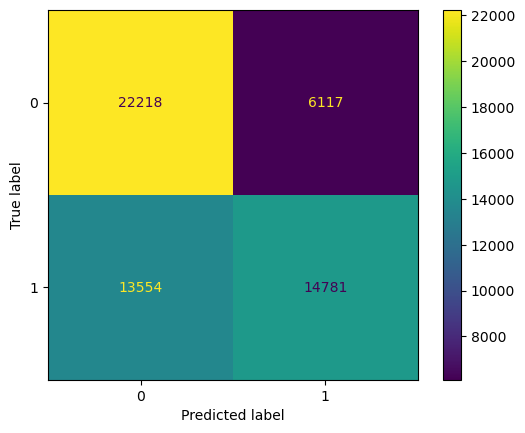

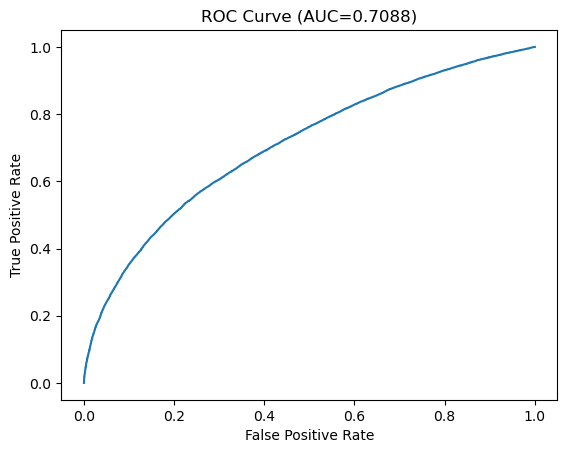

In [6]:
#Load the model
resnet_rf = pickle.load(open('../Classification models/resnet_rf.pkl', 'rb'))

resnet_rf_fpr, resnet_rf_tpr, resnet_rf_score = measure_performance(resnet_rf, resnet_test_X, resnet_test_Y)
#np.save( ".npy", resnet_rf_fpr)
#np.save( ".npy", resnet_rf_tpr)
#np.save( ".npy", resnet_rf_score)

Accuracy: 0.6370
Precision: 0.7058
Recall: 0.4697
F1 score: 0.5641
ROC AUC score: 0.7002
Confusion matrix:
[[22787  5548]
 [15025 13310]]


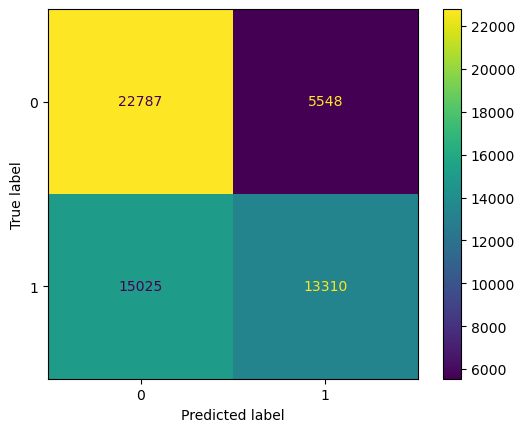

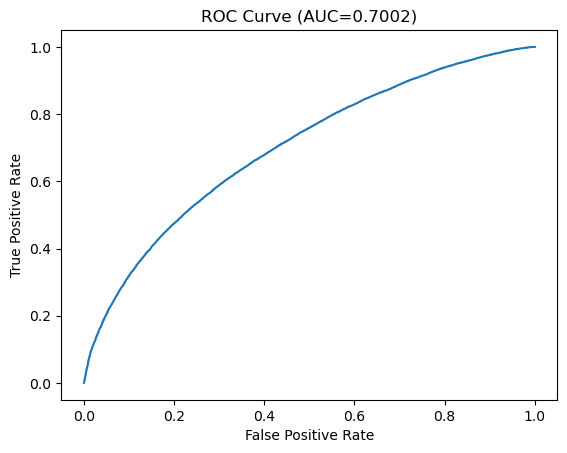

In [12]:
resnet_svm = pickle.load(open('../Classification models/resnet_svm.pkl', 'rb'))

resnet_svm_fpr, resnet_svm_tpr, resnet_svm_score = measure_performance(resnet_svm, resnet_test_X, resnet_test_Y)

1771/1771 [==============================] - 10s 6ms/step
Accuracy: 0.6301
Precision: 0.6892
Recall: 0.4738
F1 score: 0.5616
ROC AUC score: 0.6865
Confusion matrix:
[[22280  6055]
 [14909 13426]]


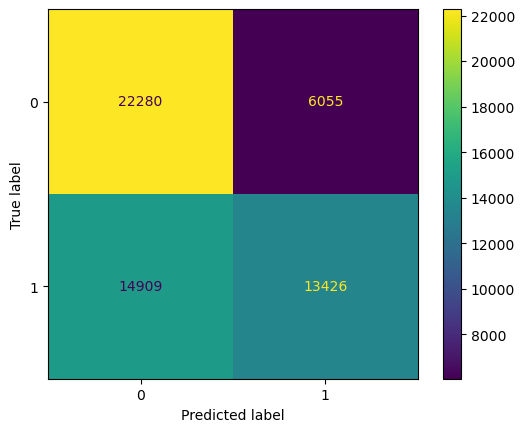

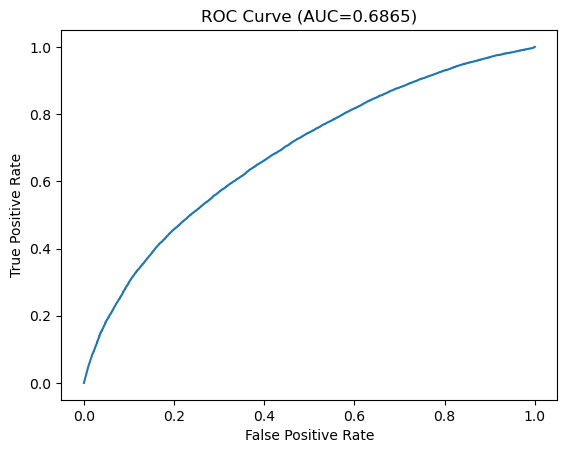

In [7]:
resnet_mlp = keras.models.load_model('../Classification models/cls-models-final/resnet_mlp')

resnet_mlp_fpr, resnet_mlp_tpr, resnet_mlp_score = measure_performance(resnet_mlp, resnet_test_X, resnet_test_Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   23.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   23.4s finished


Accuracy: 0.6283
Precision: 0.6685
Recall: 0.5090
F1 score: 0.5779
ROC AUC score: 0.6755
Confusion matrix:
[[21182  7153]
 [13913 14422]]


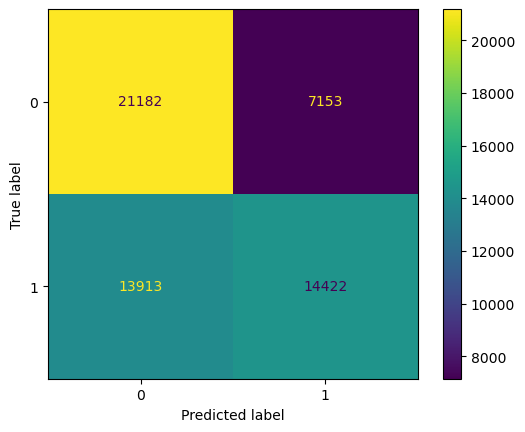

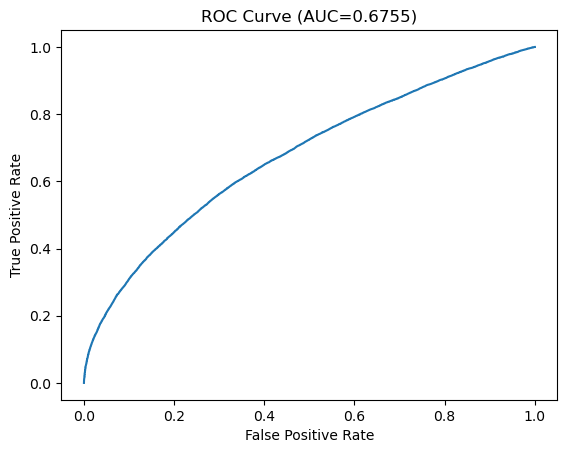

In [8]:
inception_rf = pickle.load(open('../Classification models/inception_rf.pkl', 'rb'))

inception_rf_fpr, inception_rf_tpr, inception_rf_score = measure_performance(inception_rf, inception_test_X, inception_test_Y)

Accuracy: 0.6220
Precision: 0.6662
Recall: 0.4888
F1 score: 0.5639
ROC AUC score: 0.6771
Confusion matrix:
[[21396  6939]
 [14484 13851]]


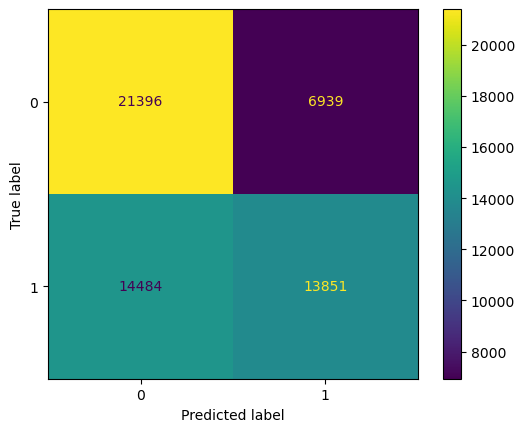

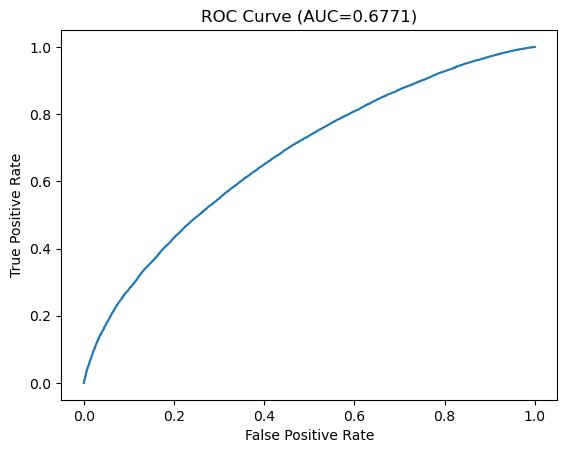

In [13]:
inception_svm = pickle.load(open('../Classification models/inception_svm.pkl', 'rb'))

inception_svm_fpr, inception_svm_tpr, inception_svm_score = measure_performance(inception_svm, inception_test_X, inception_test_Y)

1771/1771 [==============================] - 9s 5ms/step
Accuracy: 0.6187
Precision: 0.6583
Recall: 0.4938
F1 score: 0.5643
ROC AUC score: 0.6686
Confusion matrix:
[[21073  7262]
 [14344 13991]]


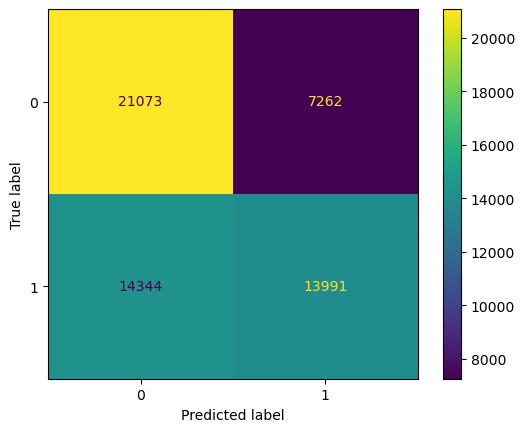

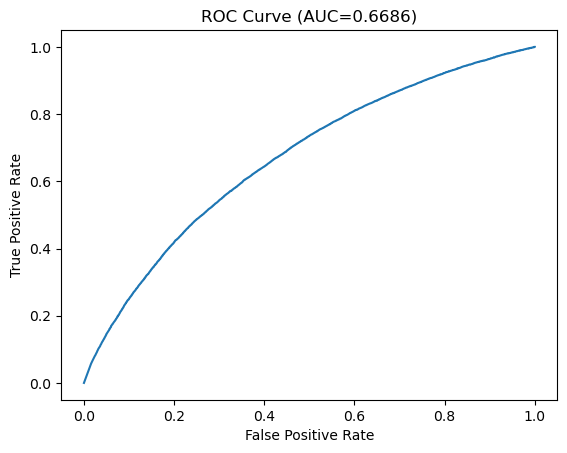

In [9]:
inception_mlp = keras.models.load_model('../Classification models/inception_mlp')

inception_mlp_fpr, inception_mlp_tpr, inception_mlp_score = measure_performance(inception_mlp, inception_test_X, inception_test_Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   21.8s finished


Accuracy: 0.6435
Precision: 0.6950
Recall: 0.5115
F1 score: 0.5893
ROC AUC score: 0.6968
Confusion matrix:
[[21975  6360]
 [13841 14494]]


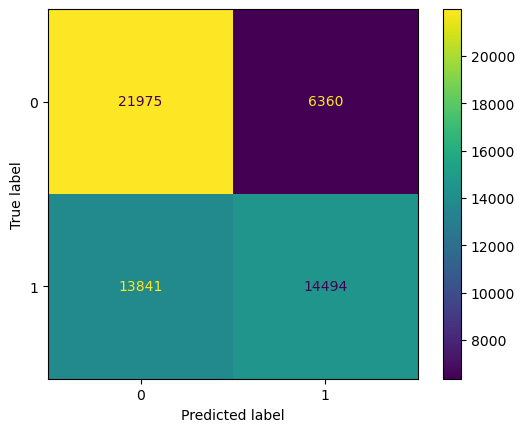

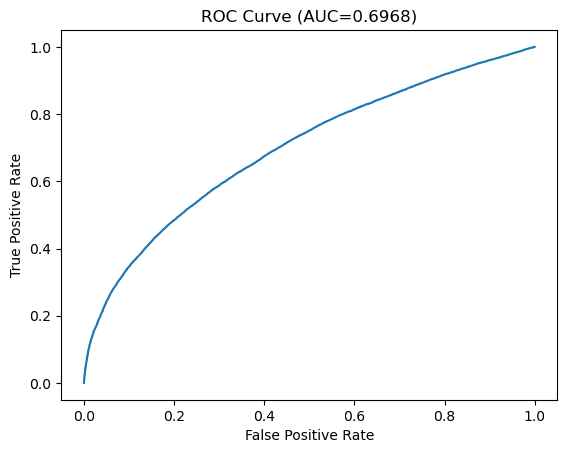

In [10]:
hybrid_rf = pickle.load(open('../Classification models/hybrid_rf.pkl', 'rb'))

hybrid_rf_fpr, hybrid_rf_tpr, hybrid_rf_score = measure_performance(hybrid_rf, hybrid_test_X, hybrid_test_Y)

Accuracy: 0.6446
Precision: 0.6953
Recall: 0.5147
F1 score: 0.5915
ROC AUC score: 0.7037
Confusion matrix:
[[21945  6390]
 [13752 14583]]


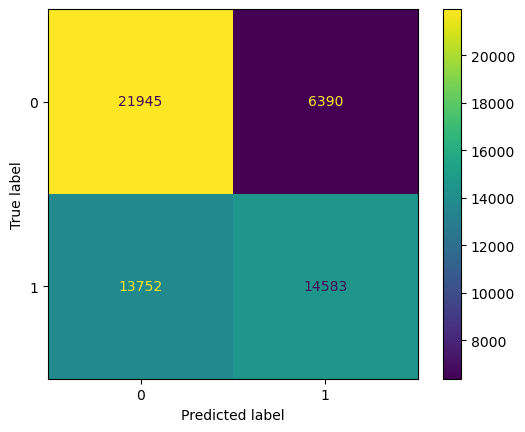

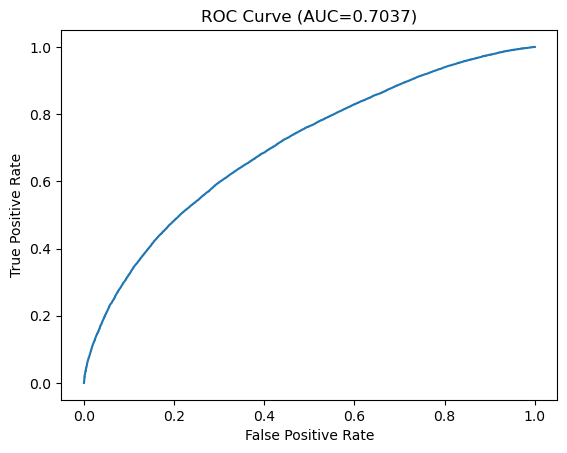

In [14]:
hybrid_svm = pickle.load(open('../Classification models/hybrid_svm.pkl', 'rb'))

hybrid_svm_fpr, hybrid_svm_tpr, hybrid_svm_score = measure_performance(hybrid_svm, hybrid_test_X, hybrid_test_Y)

1771/1771 [==============================] - 8s 5ms/step
Accuracy: 0.6311
Precision: 0.6826
Recall: 0.4899
F1 score: 0.5704
ROC AUC score: 0.6855
Confusion matrix:
[[21882  6453]
 [14454 13881]]


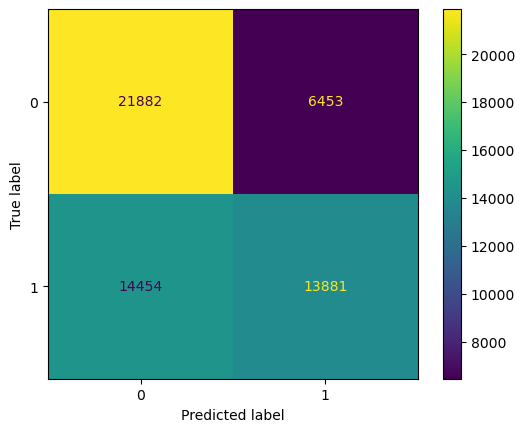

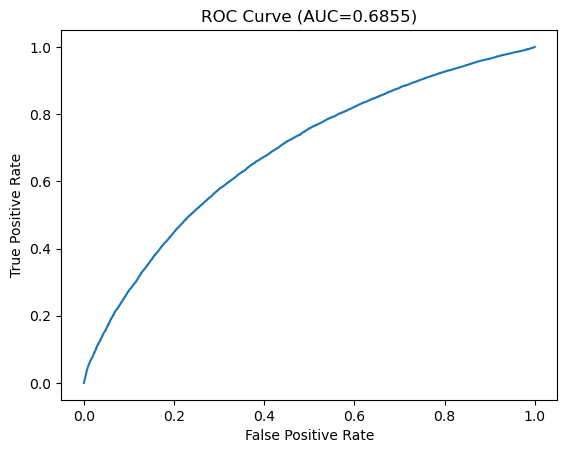

In [11]:
hybrid_mlp = keras.models.load_model('../Classification models/hybrid_mlp')

hybrid_mlp_fpr, hybrid_mlp_tpr, hybrid_mlp_score = measure_performance(hybrid_mlp, hybrid_test_X, hybrid_test_Y)

Resnet 50 + Random Forest AUCROC Score:0.7088
Resnet 50 + SVM AUCROC Score:0.7002
Resnet 50 + MLP AUCROC Score:0.6865
Inception V3 + Random Forest AUCROC Score:0.6755
Inception V3 + SVM AUCROC Score:0.6771
Inception V3 + MLP AUCROC Score:0.6686
Hybrid + Random Forest AUCROC Score:0.6968
Hybrid + SVM AUCROC Score:0.7037
Hybrid + MLP AUCROC Score:0.6855


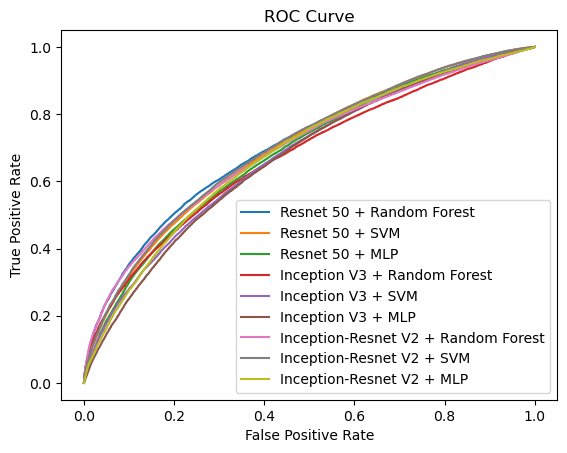

In [15]:
print(f'Resnet 50 + Random Forest AUCROC Score:{resnet_rf_score:.4f}')
print(f'Resnet 50 + SVM AUCROC Score:{resnet_svm_score:.4f}')
print(f'Resnet 50 + MLP AUCROC Score:{resnet_mlp_score:.4f}')
print(f'Inception V3 + Random Forest AUCROC Score:{inception_rf_score:.4f}')
print(f'Inception V3 + SVM AUCROC Score:{inception_svm_score:.4f}')
print(f'Inception V3 + MLP AUCROC Score:{inception_mlp_score:.4f}')
print(f'Hybrid + Random Forest AUCROC Score:{hybrid_rf_score:.4f}')
print(f'Hybrid + SVM AUCROC Score:{hybrid_svm_score:.4f}')
print(f'Hybrid + MLP AUCROC Score:{hybrid_mlp_score:.4f}')
plt.plot(resnet_rf_fpr, resnet_rf_tpr, label='Resnet 50 + Random Forest')
plt.plot(resnet_svm_fpr, resnet_svm_tpr, label='Resnet 50 + SVM')
plt.plot(resnet_mlp_fpr, resnet_mlp_tpr, label='Resnet 50 + MLP')
plt.plot(inception_rf_fpr, inception_rf_tpr, label='Inception V3 + Random Forest')
plt.plot(inception_svm_fpr, inception_svm_tpr, label='Inception V3 + SVM')
plt.plot(inception_mlp_fpr, inception_mlp_tpr, label='Inception V3 + MLP')
plt.plot(hybrid_rf_fpr, hybrid_rf_tpr, label='Inception-Resnet V2 + Random Forest')
plt.plot(hybrid_svm_fpr, hybrid_svm_tpr, label='Inception-Resnet V2 + SVM')
plt.plot(hybrid_mlp_fpr, hybrid_mlp_tpr, label='Inception-Resnet V2 + MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()